# Visualizatoin in TorchOpt

In PyTorch, if the attribute `requires_grad` a tensor is `True`, the computation graph will be created if we use the tensor to do any operations. The computation graph is implemented likes link-list -- `Tensor`s are nodes and they are linked by their attribute `gran_fn`. PyTorchViz is a Python package that uses Graphviz as a backend for plotting computation graphs. TorchOpt use PyTorchViz as the blueprint and provide more easy-to-use visualization functions on the premise of supporting all its functions.

Let's start with a simple multiplication computation graph. We declared the variable `x` with flag `requires_grad=True` and compute `y = 2 * x`. Then we visualize the computation graph of `y`.

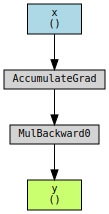

In [4]:
import torch
import TorchOpt


x = torch.tensor(1., requires_grad=True)
y = 2 * x
TorchOpt.visual.make_dot(y, params={'x': x, 'y': y})

The figure shows `y` is connected by the multiplication edge. The gradient of `y` will flow through the multiplication backward function then accumulated on x. Note that we pass a dictionary for adding node labels.

Then let's plot a neural network. Note that we can pass the generator returned by method `named_parameters` for adding node labels.

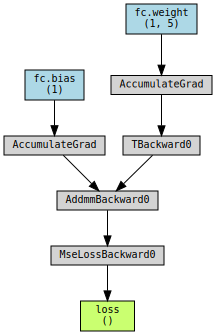

In [5]:
from torch import nn
from torch.nn import functional as F


class Net(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, 1)

    def forward(self, x):
        return self.fc(x)


dim = 5
batch_size = 2
net = Net(dim)
xs = torch.ones(batch_size, dim)
pred = net(xs)
loss = F.mse_loss(pred, torch.ones_like(pred))
TorchOpt.visual.make_dot(loss, params=(net.named_parameters(), {"loss": loss}))

The computation graph of meta learning algorithms will be much more complex. Our visualization tool allows users take as input the extracted network state for better visualization.

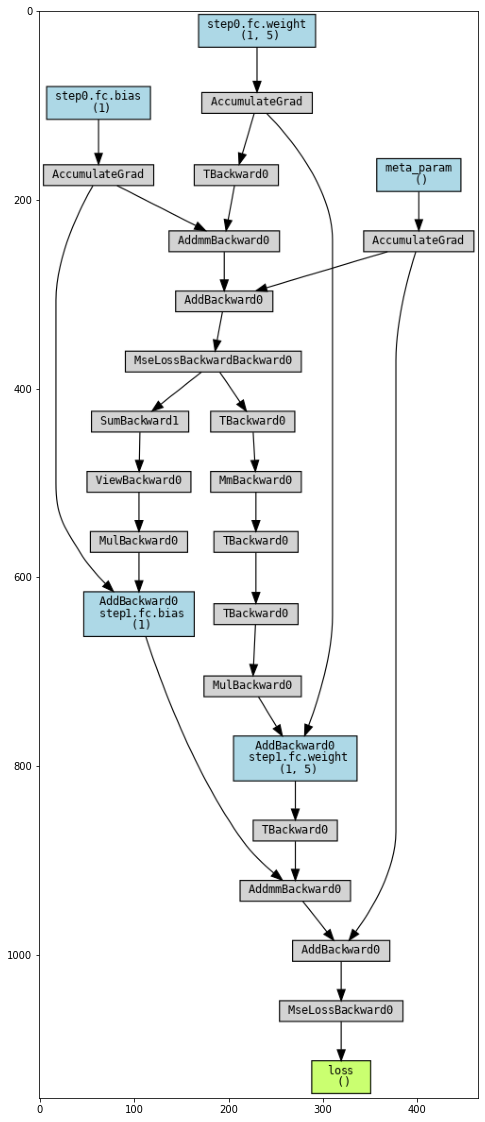

In [7]:
from matplotlib import pyplot as plt
from matplotlib import image as imgplt

class MetaNet(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, 1)

    def forward(self, x, meta_param):
        return self.fc(x) + meta_param

dim = 5
batch_size = 2
net = MetaNet(dim).cuda()
optimizer = TorchOpt.MetaSGD(net, lr=1e-3)
meta_param = torch.tensor(1., requires_grad=True)

xs = torch.ones(batch_size, dim).cuda()

pred = net(xs, meta_param)
loss = F.mse_loss(pred, torch.ones_like(pred))
# set enable_visual
net_state_0 = TorchOpt.extract_state_dict(
    net, enable_visual=True, visual_prefix='step0.')
optimizer.step(loss)
# set enable_visual
net_state_1 = TorchOpt.extract_state_dict(
    net, enable_visual=True, visual_prefix='step1.')

pred = net(xs, meta_param)
loss = F.mse_loss(pred, torch.ones_like(pred))
# draw computation graph
TorchOpt.visual.make_dot(loss,
                        [net_state_0, net_state_1,
                        {"meta_param": meta_param, 'loss': loss}]
                        ).render("meta_graph", format="png")
plt.figure(figsize=(20,20))
plt.imshow(imgplt.imread('meta_graph.png'))